# Explaining the model

## Preparing

In [1]:
files_local_location='./images'
chest_xray_directory = f"{files_local_location}/chest_xray"
validation_directory = f'{chest_xray_directory}/val'

# Hands on

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import numpy as np

from tqdm import tqdm

from config.ColorMode import ColorMode
from config.ClassificationNames import ClassificationNames

In [3]:
color_mode = ColorMode.RGB.name.lower()
image_size = (220, 220)
batch_size = 20
validation_dataset = image_dataset_from_directory(directory=validation_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=False
                                                )

Found 16 files belonging to 2 classes.


In [4]:
model_path = './model_110222_214343.h5'
# model_path = './model_102222_230735.h5'
model = tf.keras.models.load_model(filepath=model_path)


# Explanation

In [5]:
import shap

c:\Users\jamua\.conda\envs\pneumonia-classification\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
dataset_list = list(validation_dataset.take(20).as_numpy_iterator())
images_to_explain = dataset_list[0][0]
len(images_to_explain)

16

In [7]:
my_labels = dataset_list[0][1]
len(my_labels)

16

In [8]:
shap.initjs()

In [9]:

masker = shap.maskers.Image(mask_value="inpaint_telea", shape=images_to_explain[0].shape)
masker

In [10]:
class_names = list(map(lambda item: item.name,ClassificationNames.to_array()))
explainer = shap.Explainer(model=model, masker=masker, output_names=class_names)
explainer

In [11]:
max_evals = 15000
batch_size = 100

# max_evals = 50
# batch_size = 500

In [12]:
shap_values = explainer(images_to_explain, max_evals=max_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:1])

Partition explainer: 17it [1:12:59, 273.69s/it]                        


In [13]:
classification_names = ClassificationNames.to_dictionary()
true_labels = list(map(lambda element: classification_names[element],list(my_labels.flat)))
true_labels

['NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'NORMAL',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA',
 'PNEUMONIA']

In [14]:

pred = model.predict(validation_dataset)
predicted_probs = np.empty([1,1])
y_true =  np.empty([1,1])
for images, labels in tqdm(validation_dataset):
    predicted_probs = np.concatenate((predicted_probs, model(images)))
    y_true = np.concatenate([y_true, labels.numpy()])
predicted_probs = np.delete(predicted_probs, [0])
y_true = np.delete(y_true, [0])
y_pred = [1 * (x>0.5) for x in predicted_probs]

predictions_label = np.array(list(map(lambda prediction: [classification_names[prediction]], y_pred)))
print(list(zip(y_pred,predictions_label)))

1/1 [==============================] - 0s 411ms/step


100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

[(1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (0, array(['NORMAL'], dtype='<U9')), (0, array(['NORMAL'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (0, array(['NORMAL'], dtype='<U9')), (0, array(['NORMAL'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9')), (1, array(['PNEUMONIA'], dtype='<U9'))]


In [15]:
# converting shap_values.data array from float64 dtype to int32 dtype
shap_values.data = np.array(shap_values.data, np.int32)

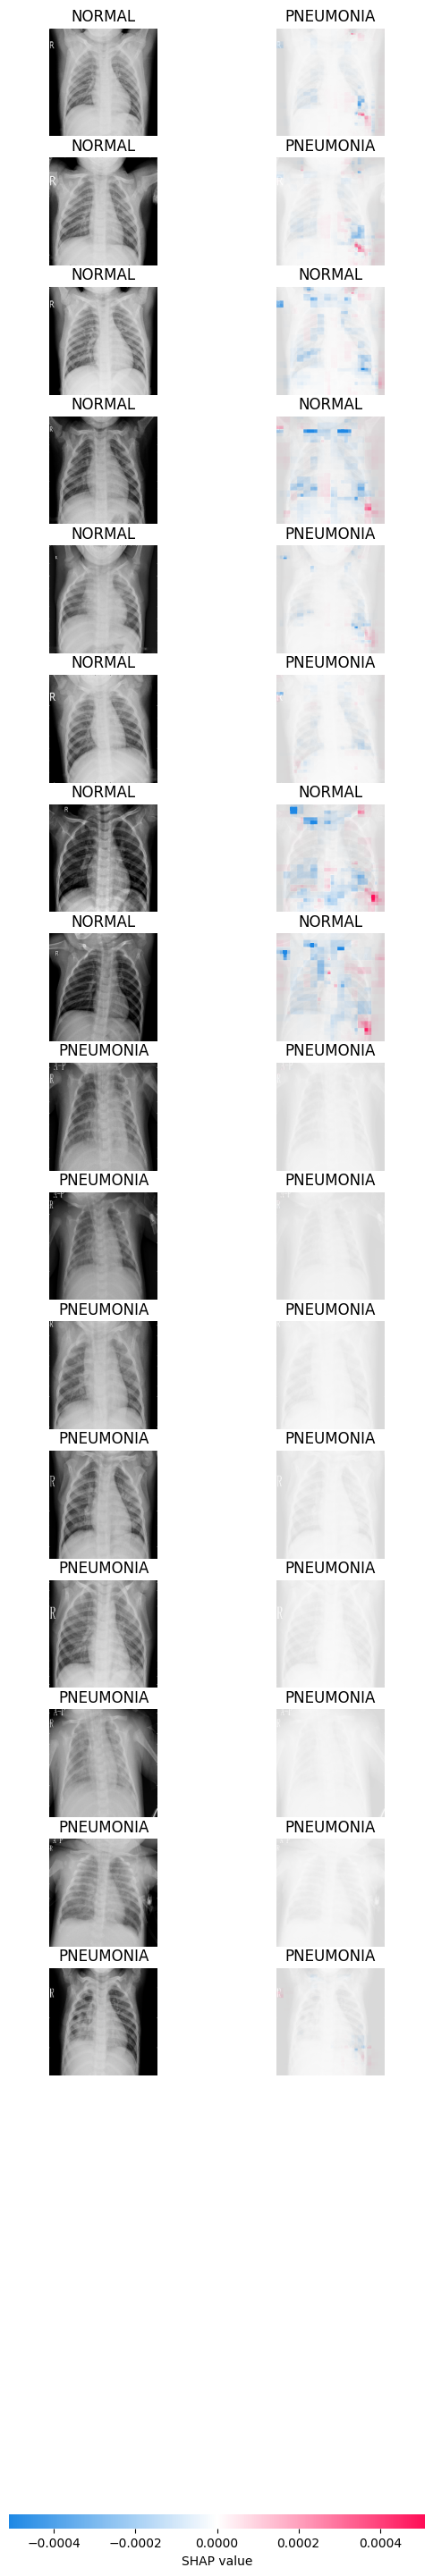

In [16]:
shap.plots.image(shap_values=shap_values,
                    true_labels=true_labels,
                    labels=predictions_label)

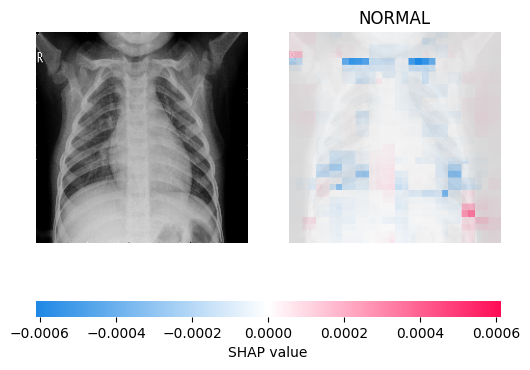

In [17]:
shap.image_plot(shap_values[3])